### Create fine SEAWAT grid from NMGWM

In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

nmgwmdir_cal = Path('../data/Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
workdir = Path('../work')
figdir = Path('../work/figs')
outputdir = Path('../work/output')
# nmgwmdir_uncal = Path('../data/Scenarios/C1/C1-12')
# nmgwmdir_uncal = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/Scenarios/C1/C1-12')
import config
from set_rc import *

flopy is installed in /Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy


In [2]:
%%time
m= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m.exe_name = config.mf2000exe

CPU times: user 13.8 s, sys: 477 ms, total: 14.3 s
Wall time: 14.8 s


In [ ]:
#New model
model_ws = workdir.joinpath('nmgwm_seawat')
if not model_ws.exists():
    model_ws.mkdir()
mn = flopy.seawat.Seawat('nmgwm_seawat', exe_name=config.swexe, model_ws=model_ws.as_posix())

### DIS

In [3]:
if not m.DIS.lenuni==2:
    m.DIS.delr *= .3048
    m.DIS.delc *= .3048
    m.DIS.top *= .3048
    m.DIS.botm *= .3048
    m.DIS.lenuni = 2
    m.DIS.rotation=-13.5
    m.DIS.xul = 59855 + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
    m.DIS.yul = 4059438 + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
    m.DIS.proj4_strstr = '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs'

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


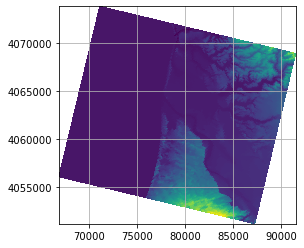

In [4]:
# m.DIS.xul = 59855 #- 18288.0*np.cos(13.5*180/np.pi) #upper left UTM Zone 10N
# m.DIS.yul = 4059438 #+ 18288.0*np.sin(13.5*180/np.pi)  #upper left UTM Zone 10N
    
slicenum=0
f,ax = plt.subplots(1)
mapview = flopy.plot.ModelMap(ax=ax,model=m,layer=slicenum,dis=m.DIS,xul=m.DIS.xul,yul=m.DIS.yul,rotation=m.DIS.rotation)
# ibound = mapview.plot_ibound()
a = m.DIS.top.array.astype(np.float)
mapview.plot_array(a)
# mapview.plot_grid()
g = mapview.plot_bc("GHB")
ax.set_aspect(1)
ax.grid(True)

#### Define new discretization

In [548]:
# delr = 30.
# delc = 30.
# delv = 3.

delr = m.DIS.delr.array[0]
delc = m.DIS.delc.array[0]
delv = 5.
nlay_1thru5 = 50
nlay=nlay_1thru5+1

ncol =  np.floor(np.sum(m.DIS.delr.array)/delr).astype(int)
nrow = np.floor(np.sum(m.DIS.delc.array)/delc).astype(int)

colvec = np.arange(0,ncol*delr,delr)
rowvec= np.arange(0,nrow*delc,delc)


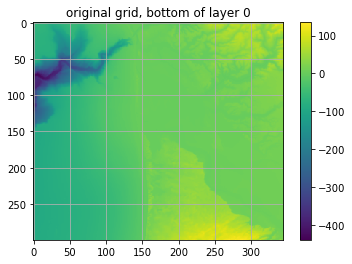

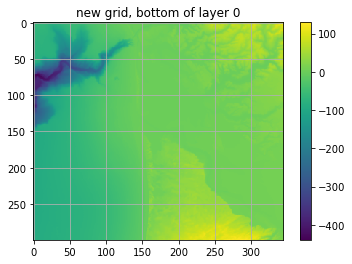

In [549]:
lay = 0

plt.figure()
plt.imshow(m.DIS.botm.array[lay])
plt.colorbar()
plt.title('original grid, bottom of layer {}'.format(lay))
plt.gca().grid()

spl = RectBivariateSpline(x=np.cumsum(m.DIS.delc.array),
                        y=np.cumsum(m.DIS.delr.array),
                        z=m.DIS.botm.array[lay])


new_eval = spl(rowvec,colvec)
plt.figure()
plt.imshow(new_eval)
plt.colorbar()
plt.title('new grid, bottom of layer {}'.format(lay))
plt.gca().grid()


In [550]:
from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator
xx,yy = np.meshgrid(np.cumsum(m.DIS.delc.array),np.cumsum(m.DIS.delr.array))
xxn,yyn = np.meshgrid(np.cumsum(mn.DIS.delc.array),np.cumsum(mn.DIS.delr.array))

def interp_surf2newgrid(orig_values):
    return RectBivariateSpline(x=np.cumsum(m.DIS.delc.array),
                                y=np.cumsum(m.DIS.delr.array),
                                z=orig_values)(rowvec,colvec).round(decimals=1)

def NN_surf2newgrid(orig_values):
    d = orig_values.dtype
    interp_obj = NearestNDInterpolator(x=(xx.flatten(),yy.flatten()),y=orig_values.T.flatten())
    return interp_obj((xxn.flatten(),yyn.flatten())).reshape((mn.DIS.nrow,mn.DIS.ncol),order='F').astype(d)



In [551]:
botm_orig= m.DIS.botm.array[:6]


top = interp_surf2newgrid(m.DIS.top.array)
botm0 = interp_surf2newgrid(m.DIS.botm.array[0])
botm_lay1thru5 = np.zeros((nlay_1thru5,nrow,ncol))
for i in range(nrow):
    if i%100==0:
        print('Row',i)
    for j in range(ncol):
        botm_lay1thru5[:,i,j] = np.arange(botm0[i,j]-delv ,  botm0[i,j] - delv*nlay_1thru5-delv/2,-delv)
        
botm = np.concatenate((botm0[np.newaxis,...],botm_lay1thru5),axis=0)

Row 0
Row 100
Row 200


In [552]:
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros_like(botm,dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
        botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        ind_inlay =botm<botm_orig_lay
    else:
        botm_orig_lay = interp_surf2newgrid(botm_orig[lay])
        top_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        ind_inlay =np.logical_and(botm>=botm_orig_lay,botm<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay

In [553]:
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


In [554]:
dis = flopy.modflow.mfdis.ModflowDis(mn,nlay=nlay,nrow=nrow,ncol=ncol,
                                     delr=delr,delc=delc,
                                     top=top,botm=botm,laycbd=0,
                                     perlen=m.DIS.perlen.array,nper=m.DIS.nper,tsmult=m.DIS.tsmult.array,
                                     itmuni=4,lenuni=2,steady=False)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


#### BAS

In [555]:
ibound= np.ones_like(botm,dtype=np.int)
for lay in range(m.DIS.nlay):
    print(lay)
    ibound_lay = NN_surf2newgrid(m.bas6.ibound.array[lay])
    for newlay in range(nlay):
        ibound[lay][layer_mapping_ind[newlay]==lay]=ibound_lay[layer_mapping_ind[newlay]==lay]
        
strt = np.ones_like(ibound,dtype=np.float)
strt[ibound<0]=0

bas = flopy.modflow.mfbas.ModflowBas(mn,ibound=ibound,strt=strt)

0
1
2
3
4
5
6
7


#### LPF

In [556]:
hk = np.ones_like(botm)
hk[ibound<0]=7500
hk[np.isin(layer_mapping_ind,(1,3,5,7))]=.01
hk[np.isin(layer_mapping_ind,(2,4,6))]=10

In [557]:
laytyp = np.zeros(nlay)
laytyp[0]=1

lpf = flopy.modflow.mflpf.ModflowLpf(mn,
                                    laytyp=laytyp,hk=hk)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


## Transport

#### BTN, ADV, DSP, GCG

In [559]:
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)



icbund = np.ones_like(ibound,dtype=int)
icbund[ibound<0] = -1
icbund[ibound==0] = 0


sconc = np.zeros_like(ibound,dtype=np.float)
sconc[icbund<0]=Csalt

prsity= 0.2
sconc=0.
al = 10
dmcoef = 1e-9
timprs = np.cumsum(mn.DIS.perlen.array)


btn=flopy.mt3d.Mt3dBtn(mn,
                laycon=mn.lpf.laytyp, htop=mn.DIS.top.array,
                dz=mn.DIS.thickness.get_value(), prsity=prsity, icbund=icbund,
                sconc=sconc, nprs=1, timprs=timprs)
adv=flopy.mt3d.Mt3dAdv(mn, mixelm=-1)
dsp=flopy.mt3d.Mt3dDsp(mn , al=al, dmcoef=dmcoef)
gcg=flopy.mt3d.Mt3dGcg(mn , iter1=50, mxiter=1, isolve=1, cclose=1e-5)

****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtadv.Mt3dAdv'> <class 'flopy.mt3d.mtadv.Mt3dAdv'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtgcg.Mt3dGcg'> <class 'flopy.mt3d.mtgcg.Mt3dGcg'>
replacing existing Package...


In [675]:
sconc = np.zeros_like(ibound,dtype=np.float)
sconc[icbund<0]=Csalt


#### SSM


In [637]:
ghb_orig = m.GHB.stress_period_data.data
ghb_new =  {}

for kper in range(mn.DIS.nper):
    ghb_kper=[]
    if kper%50==0:
        print('kper',kper)
    for v in ghb_orig[kper]:
        lays = np.argwhere(layer_mapping_ind[:,v[1],v[2]]==v[0])
        for l in lays:
            ghb_kper.append([int(l),
                            v[1],
                            v[2],
                            v[3],
                            v[4]])
    ghb_new[kper]=ghb_kper

kper 0
kper 50
kper 100
kper 150
kper 200
kper 250
kper 300
kper 350


In [648]:
ghb = flopy.modflow.ModflowGhb(mn, stress_period_data=ghb_new)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...


#### SSM

In [647]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_new =  {}


print('Adding Inland SSM...')
#GHB
for kper in range(mn.DIS.nper):
    ssm_kper = []
    if kper%100==0:
        print('kper',kper)
    for v in ghb_new[kper]:
        ssm_kper.append([v[0],
                        v[1],
                        v[2],
                        Cfresh,
                        itype['GHB']])
    ssm_new[kper] = ssm_kper

        
print('Adding Ocean SSM...')
#Ocean
for kper in range(mn.DIS.nper):
    if kper%100==0:
        print('kper',kper)
    for v in np.argwhere(ibound<0):
        ssm_new[kper].append([v[0],
                        v[1],
                        v[2],
                        Csalt,
                        itype['CHD']])

Adding Inland SSM...
kper 0
kper 100
kper 200
kper 300
Adding Ocean SSM...
kper 0
kper 100
kper 200
kper 300


In [650]:
ssm = flopy.mt3d.Mt3dSsm(mn, stress_period_data=ssm_new)


#### VDF

In [651]:
vdf = flopy.seawat.SeawatVdf(mn, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1,
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


****Warning -- two packages of the same type:  <class 'flopy.seawat.swtvdf.SeawatVdf'> <class 'flopy.seawat.swtvdf.SeawatVdf'>
replacing existing Package...


#### OC

In [660]:
oc_data={}
for kper in range(mn.DIS.nper):
    if kper % 5==0:
        oc_data[(kper, 0)] = ['save head', 'save budget']
oc =  flopy.modflow.ModflowOc(mn,stress_period_data=oc_data,compact=True)


#### Write it all

In [663]:
%%time
write_all=False

if write_all:
    print('Writing input, this will take a while...')
    mn.write_input()
else:
    print('Not writing input!!')

# # Try to delete the output files, to prevent accidental use of older files
# flist = [os.path.join(model_ws, 'MT3D.CNF'),
#          os.path.join(model_ws, 'MT3D001.MAS'),
#          os.path.join(model_ws, modelname + '.hds'),
#          os.path.join(model_ws, 'MT3D001.UCN'),
#          os.path.join(model_ws, 'MT3D001.UCN'),
#          os.path.join(model_ws, modelname + '.cbc')]
# for f in flist:
#     try:
#         os.remove(f)
#     except:
#         pass

Not writing input!!
CPU times: user 261 µs, sys: 106 µs, total: 367 µs
Wall time: 295 µs


In [664]:
mn.run_model()

FloPy is using the following  executable to run the model: /usr/local/bin/MODFLOW/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: nmgwm_seawat.nam                                                                                                                                                                                        
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/20  9:36:33


 STRESS PERIOD NO.    1

  STRESS PERIO

KeyboardInterrupt: 

### Plotting

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


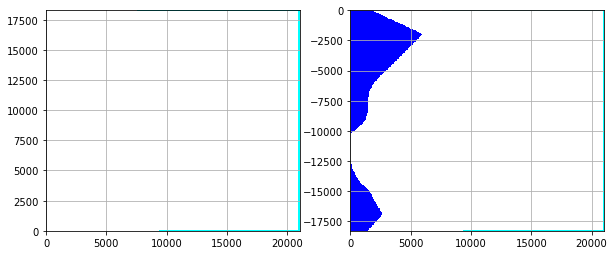

In [631]:
slicenum=20


f,axs = plt.subplots(1,2,figsize=(10,10))
plt.sca(axs[0])
ax = plt.gca()

mapview = flopy.plot.ModelMap(ax=ax,model=mn,layer=slicenum,dis=mn.DIS)
patches = mapview.plot_ibound()
patches = mapview.plot_bc('GHB')

# a = m.DIS.top.array.astype(np.float) -  m.DIS.botm.array.astype(np.float)[0]
# p = mapview.plot_array(a)
# plt.colorbar(p)
# mapview.plot_grid()
ax.set_aspect(1)
ax.grid(True)


slicenum=5
plt.sca(axs[1])
ax = plt.gca()
mapview = flopy.plot.ModelMap(ax=ax,model=m,layer=slicenum,dis=m.DIS, rotation=0,xul=0,yul=0)
patches = mapview.plot_ibound()
patches = mapview.plot_bc('GHB')

# a = m.DIS.top.array.astype(np.float) -  m.DIS.botm.array.astype(np.float)[0]
# p = mapview.plot_array(a)
# plt.colorbar(p)
# mapview.plot_grid()
ax.set_aspect(1)
ax.grid(True)


Text(0.5, 0, 'Distance (m)')

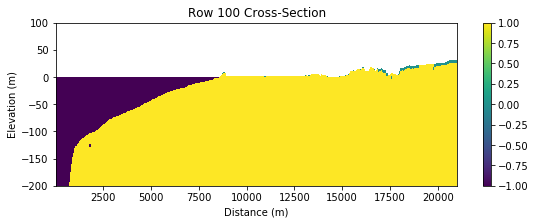

In [669]:
from matplotlib import cm

slicetype='Row'
slicenum= 100

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=mn, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(mn.BTN.icbund.array,cmap='viridis')
c = plt.colorbar(csa)
# # wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

Text(0.5, 0, 'Distance (m)')

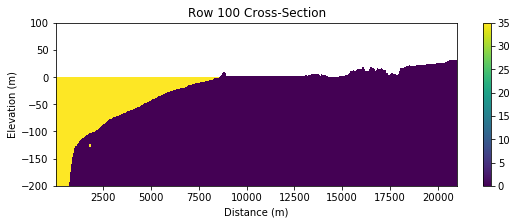

In [676]:
from matplotlib import cm

slicetype='Row'
slicenum= 100

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=mn, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(sconc,cmap='viridis')
c = plt.colorbar(csa)
# # wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [674]:
mn.BTN.sconc

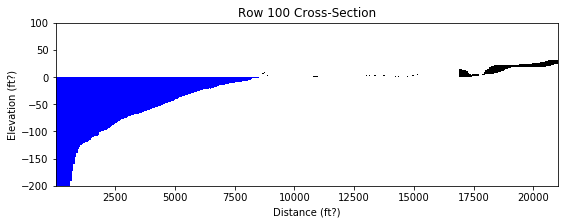

In [577]:
from matplotlib import cm

slicetype='Row'
slicenum= 100

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
patches = xsect.plot_ibound()
# a= m.lpf.hk.array
# a[a<=0]=np.nan
# a=np.log(a)


# lay_m = np.zeros_like(m.lpf.hk.array)
# for lay in range(lay_m.shape[0]):
#     lay_m[lay,:,:]=lay
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# csa = xsect.plot_array(lay_m,cmap=cmap)
# c = plt.colorbar(csa)
# # wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (ft?)')
plt.ylim((-200,100))
plt.xlabel('Distance (ft?)')
# c.set_label('log10(hk)')
plt.savefig(figdir.joinpath('NMGWM_orig_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

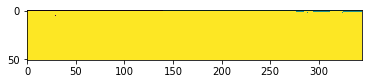

In [667]:
icbund = mn.BTN.icbund.array

plt.imshow(icbund[:,100,:])